In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import random

# 데이터 로드
file_path = '/content/drive/MyDrive/Colab_Notebooks/Data2/ELG_Busan_PoC_per_CA_site_0226_0519.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head()

(5199888, 30)


,Unnamed: 0,timestamp,hour,Holiday,enb_id,pci,Vendor,ru_svc_lat_val,ru_svc_lng_val,Equip_800,...,User_800,User_1800,User_2100,User_2600_10,User_2600_20,Usertotal,enbid_pci,cell_group,CAnum,RBused
0,0,2024-02-26 00:00:00,00:00,0,33011,221.0,ELG,35.188059,129.083615,1,...,18.0,28.0,10.0,2.0,58.0,116.0,33011_221,0|27|4|7|8,5,67.8875
1,1,2024-02-26 00:00:00,00:00,0,33011,304.0,ELG,35.186121,129.080416,1,...,18.0,37.0,8.0,0.0,45.0,108.0,33011_304,1|12|32|5|9,5,28.1875
2,2,2024-02-26 00:00:00,00:00,0,33011,348.0,ELG,35.187576,129.082069,1,...,14.0,15.0,9.0,0.0,50.0,88.0,33011_348,10|13|2|33|6,5,51.4525
3,3,2024-02-26 00:00:00,00:00,0,33169,162.0,ELG,35.173889,128.984444,1,...,12.0,36.0,11.0,1.0,72.0,132.0,33169_162,11|14|2|5|8,5,31.0725
4,4,2024-02-26 00:00:00,00:00,0,33169,246.0,ELG,35.167666,128.977222,1,...,12.0,35.0,13.0,1.0,93.0,154.0,33169_246,1|10|13|4|7,5,54.4475


In [29]:
def clean_column_names(df):
    df.columns = [re.sub(r'[^\w\s]', '_', col) for col in df.columns]
    df.columns = ['feature_'+col if col[0].isdigit() else col for col in df.columns]
    df.columns = [col.strip('_') for col in df.columns]
    return df

def prepare_features(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    for col in ['Holiday', 'Vendor']:
        df[col] = df[col].astype('category').cat.codes

    targets = ['RBused', 'RB_800', 'RB_1800', 'RB_2100', 'RB_2600_10', 'RB_2600_20']
    for target in targets:
        df[f'{target}_lag_1h'] = df.groupby(['enb_id', 'pci'])[target].shift(1)
        df[f'{target}_lag_24h'] = df.groupby(['enb_id', 'pci'])[target].shift(24)
        df[f'{target}_lag_168h'] = df.groupby(['enb_id', 'pci'])[target].shift(168)

    # Moving average 특성 추가
    for target in targets:
        for window in [3, 6, 12, 24]:
            df[f'{target}_ma_{window}h'] = df.groupby(['enb_id', 'pci'])[target].rolling(window=window).mean().reset_index(level=[0,1], drop=True)

    df['User_RB_ratio'] = df['Usertotal'] / df['RBtotal']

    df['timestamp_int'] = df['timestamp'].astype(int) // 10**9

    df = clean_column_names(df)

    return df

# 데이터 전처리 적용
df = prepare_features(df)
df = df.dropna()
print(df.shape)
df.head()

(5089604, 78)


,Unnamed_ 0,timestamp,hour,Holiday,enb_id,pci,Vendor,ru_svc_lat_val,ru_svc_lng_val,Equip_800,...,RB_2600_10_ma_3h,RB_2600_10_ma_6h,RB_2600_10_ma_12h,RB_2600_10_ma_24h,RB_2600_20_ma_3h,RB_2600_20_ma_6h,RB_2600_20_ma_12h,RB_2600_20_ma_24h,User_RB_ratio,timestamp_int
108528,108528,2024-02-27 18:00:00,18,0,33011,221.0,0,35.188059,129.083615,1,...,4.590000,4.586667,5.717083,4.942917,37.243333,35.490000,38.355833,36.407500,0.816000,1709056800
108529,108529,2024-02-27 18:00:00,18,0,33011,304.0,0,35.186121,129.080416,1,...,2.016667,2.502500,2.183750,2.050417,26.706667,26.466667,24.436667,22.255417,0.754667,1709056800
108530,108530,2024-02-27 18:00:00,18,0,33011,348.0,0,35.187576,129.082069,1,...,1.400000,1.458333,1.690833,1.647708,12.710000,12.371667,15.259167,15.048750,0.373333,1709056800
108531,108531,2024-02-27 18:00:00,18,0,33169,162.0,0,35.173889,128.984444,1,...,2.161667,1.826667,1.621250,1.700625,26.900000,23.541667,20.532500,21.715417,0.733333,1709056800
108532,108532,2024-02-27 18:00:00,18,0,33169,246.0,0,35.167666,128.977222,1,...,1.018333,1.265000,1.113333,1.061458,5.990000,6.291667,6.019167,6.106250,0.320000,1709056800


In [30]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return rmse, mae, r2

def train_lightgbm_model(X, y, tscv):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1
    }

    train_data = lgb.Dataset(X, label=y)
    initial_model = lgb.train(params, train_data, num_boost_round=100)
    feature_importance = initial_model.feature_importance()
    top_features = X.columns[np.argsort(feature_importance)[-20:]].tolist()
    X = X[top_features]

    models = []
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)

        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            callbacks=[early_stopping_callback]
        )

        y_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        models.append(model)
        scores.append(score)

    best_model = models[np.argmin(scores)]
    return best_model, np.mean(scores), top_features

In [31]:
# 타겟 변수 및 특성 정의
targets = ['RBused', 'RB_800', 'RB_1800', 'RB_2100', 'RB_2600_10', 'RB_2600_20']
feature_columns = [col for col in df.columns if col not in targets and df[col].dtype in ['int64', 'float64', 'bool']]

# 데이터 분할 (80% 훈련, 20% 테스트)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 시계열 분할 객체 생성
tscv = TimeSeriesSplit(n_splits=3)

# 모델 학습
models = {}
for target in targets:
    print(f"Training model for {target}...")
    X = train_df[feature_columns]
    y = train_df[target]
    model, score, top_features = train_lightgbm_model(X, y, tscv)
    models[target] = (model, top_features)
    print(f"{target} model average RMSE: {score}")

    # 모델 평가
    rmse, mae, r2 = evaluate_model(model, X[top_features], y)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

print("Training and evaluation complete!")

Training model for RBused...
RBused model average RMSE: 4.684984668736775
RMSE: 4.5319, MAE: 2.6472, R^2: 0.9381
Training model for RB_800...
RB_800 model average RMSE: 2.012586610295752
RMSE: 1.9702, MAE: 1.0508, R^2: 0.8773
Training model for RB_1800...
RB_1800 model average RMSE: 2.6707522725886714
RMSE: 2.5868, MAE: 1.3989, R^2: 0.8987
Training model for RB_2100...
RB_2100 model average RMSE: 0.9581816657363907
RMSE: 0.9268, MAE: 0.3811, R^2: 0.9118
Training model for RB_2600_10...
RB_2600_10 model average RMSE: 0.29928551226479455
RMSE: 0.2921, MAE: 0.0764, R^2: 0.9260
Training model for RB_2600_20...
RB_2600_20 model average RMSE: 1.2653030162215055
RMSE: 1.2410, MAE: 0.4723, R^2: 0.9626
Training and evaluation complete!


In [34]:
def plot_actual_vs_predicted(model, X, y, target):
    y_pred = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted - {target}')
    plt.show()

def predict_for_enbid_pci(model, df, enbid_pci, target, feature_columns):
    specific_data = df[df['enbid_pci'] == enbid_pci]

    if specific_data.empty:
        print(f"No data found for enbid_pci {enbid_pci}")
        return None, None

    X = specific_data[feature_columns]
    predictions = model.predict(X)

    return specific_data['timestamp'], predictions

def plot_actual_vs_predicted_timeseries(df, model, enbid_pci, target, feature_columns):
    # 특정 enbid_pci에 대한 데이터만 필터링
    specific_data = df[df['enbid_pci'] == enbid_pci].sort_values('timestamp')

    X = specific_data[feature_columns]
    y_true = specific_data[target]
    y_pred = model.predict(X)

    plt.figure(figsize=(20, 5))
    plt.plot(specific_data['timestamp'], y_true, label='Actual', alpha=0.7)
    plt.plot(specific_data['timestamp'], y_pred, label='Predicted', alpha=0.7)
    plt.legend()
    plt.title(f'Actual vs Predicted {target} for enbid_pci {enbid_pci}')
    plt.xlabel('Timestamp')
    plt.ylabel(target)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

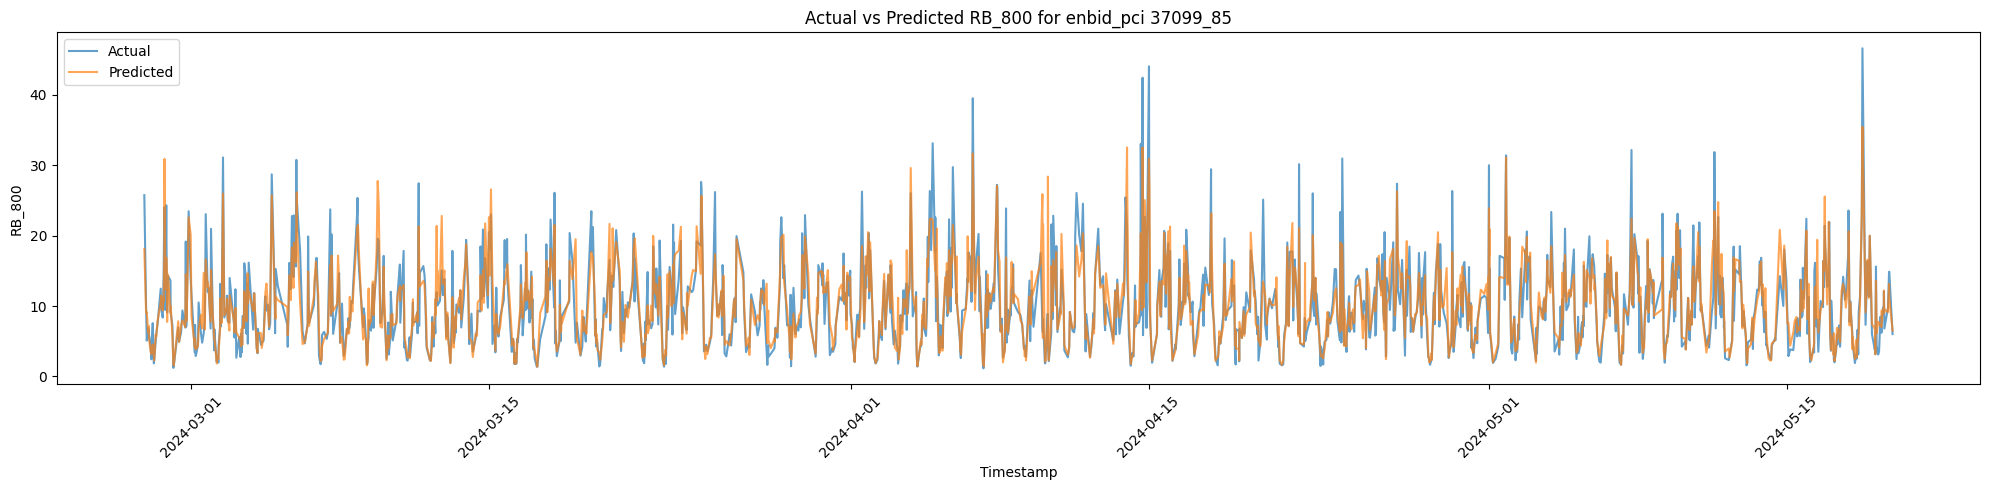

Visualization complete for enbid_pci 37099_85


In [35]:
# RB_800에 대한 시계열 예측 시각화
target = 'RB_800'
model, top_features = models[target]
random_enbid_pci = test_df['enbid_pci'].sample(1).iloc[0]
plot_actual_vs_predicted_timeseries(test_df, model, random_enbid_pci, target, top_features)

print(f"Visualization complete for enbid_pci {random_enbid_pci}")